In [1]:
file_id_train = "17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT" #links = 2 (472827)events
file_id_val = "1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg" #links = 1 (920599)events

#!gdown https://drive.google.com/uc?id={file_id_train}
#!gdown https://drive.google.com/uc?id={file_id_val}
!ls

!pip install nflows
!pip install nvitop

'Originale_(1).ipynb'   README.md
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from torch import optim
from sklearn import preprocessing
import scipy.special

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import gc

In [5]:
labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
num_features = len(labels_map)

index_int = np.append(np.arange(12,19),[22,23])
index_float = np.append(np.arange(0,12),np.arange(19,22))

In [7]:
x = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset.txt", delimiter=',')
L=len(x)
print(L)

472827


In [ ]:
x = x[:int(L/8),:]
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]

print('Eventi =',len(x))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

xtr = np.copy(x)
xtrval = np.copy(xval)

#we shift so as to avoid applying the logarithm to numbers in (0,1), log per smussare i picchi
xtr = np.log(10 + x)


xtrval = np.log(10 + xval)
#xtrval[:,3] = np.log(1 + xval[:,3])


#standardization of the dataset
scaler = preprocessing.StandardScaler().fit(xtr)
xtr = scaler.transform(xtr)



scaler = preprocessing.StandardScaler().fit(xtrval)
xtrval = scaler.transform(xtrval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Eventi = 59103
attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



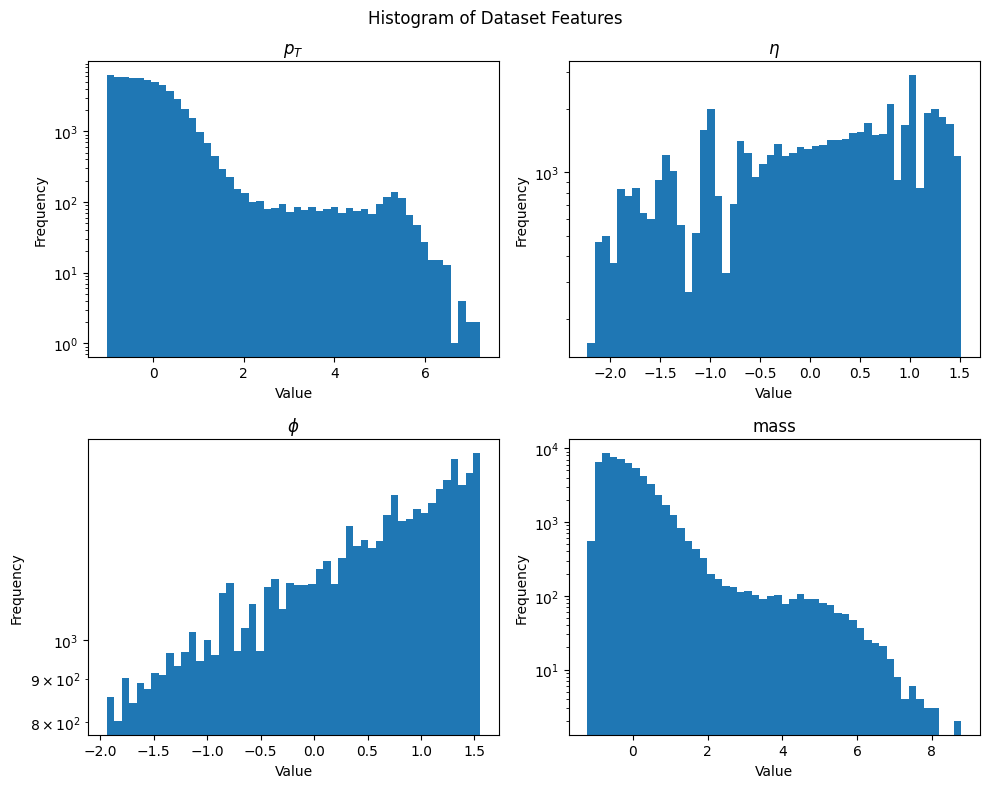

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Dataset Features")
n_bins = 50

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)


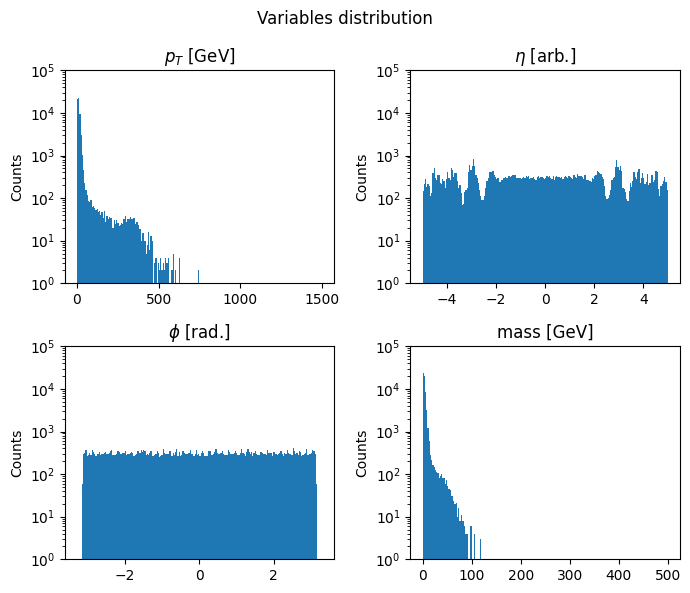

In [ ]:
fig,axs = plt.subplots(2, 2,figsize=(7,6))
fig.suptitle("Variables distribution")

axs[0, 0].hist(x[:,0],bins=200, range=(0,1500))
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=200, range=(-5,5))
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=200, range=(-3.30,3.30))
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=200, range=(0,500))
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

In [ ]:
num_iterations = 8
num_features=4 #just for testing

base_dist = StandardNormal(shape=[num_features])

transforms = []
for _ in range(num_iterations):
  transforms.append(ReversePermutation(features=num_features))
  transforms.append(MaskedAffineAutoregressiveTransform(features=num_features,hidden_features=128))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
tp = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(tp)
optimizer = optim.Adam(flow.parameters())

flow = flow.to('cuda')


541760


50 tensor(3.2805, device='cuda:0', grad_fn=<NegBackward0>)
100 tensor(3.0380, device='cuda:0', grad_fn=<NegBackward0>)
150 tensor(2.8452, device='cuda:0', grad_fn=<NegBackward0>)
200 tensor(2.7507, device='cuda:0', grad_fn=<NegBackward0>)
250 tensor(2.7100, device='cuda:0', grad_fn=<NegBackward0>)
300 tensor(2.6962, device='cuda:0', grad_fn=<NegBackward0>)
350 tensor(2.6524, device='cuda:0', grad_fn=<NegBackward0>)
400 tensor(2.6312, device='cuda:0', grad_fn=<NegBackward0>)
450 tensor(2.6477, device='cuda:0', grad_fn=<NegBackward0>)
500 tensor(2.5925, device='cuda:0', grad_fn=<NegBackward0>)
550 tensor(2.6085, device='cuda:0', grad_fn=<NegBackward0>)
600 tensor(2.5605, device='cuda:0', grad_fn=<NegBackward0>)
650 tensor(2.5521, device='cuda:0', grad_fn=<NegBackward0>)
700 tensor(2.5451, device='cuda:0', grad_fn=<NegBackward0>)
750 tensor(2.5293, device='cuda:0', grad_fn=<NegBackward0>)
800 tensor(2.5293, device='cuda:0', grad_fn=<NegBackward0>)
850 tensor(2.5076, device='cuda:0', grad_

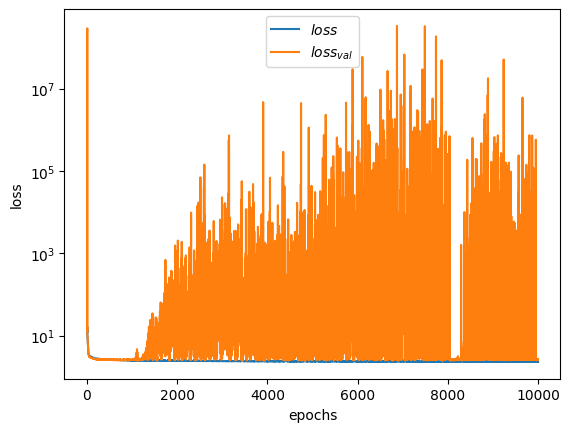

In [ ]:
num_iter = 10000

figloss=plt.figure()
loss_values = []
loss_validation = []
for i in range(num_iter):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 50 == 0:
    print(i+1,loss)

plt.plot(range(1, num_iter+1), loss_values, label='$loss$')
plt.plot(range(1, num_iter+1), loss_validation,label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

In [ ]:
sample = flow.sample(int(len(x)))
print(sample.shape)
sample = sample.cpu()
sample = sample.detach().numpy()


torch.Size([59103, 4])


In [ ]:
sample = scaler.inverse_transform(sample)
#sample = scipy.special.erf(sample)
sample = np.exp(sample) - 10


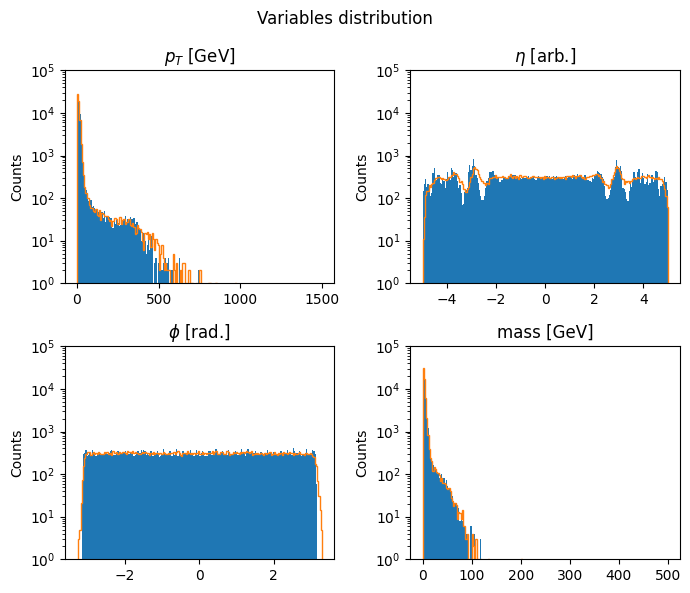

In [ ]:
fig,axs = plt.subplots(2, 2,figsize=(7,6))
fig.suptitle("Variables distribution")
n_bins = 50

axs[0, 0].hist(x[:,0],bins=n_bins, range=(0,1500))
axs[0, 0].hist(sample[:,0],bins=n_bins, range=(0,1500),histtype='step')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step')
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step')
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, range=(0,500))
axs[1, 1].hist(sample[:,3],bins=n_bins, range=(0,500),histtype='step')
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_reconstruction.pdf',dpi=190)

In [ ]:
torch.cuda.empty_cache()
gc.collect()
next(flow.parameters()).is_cuda

True